# code from calmap package

single file at https://github.com/martijnvermaat/calmap/blob/master/calmap/__init__.py

Licensed under MIT

This can be included as a sub folder underneath the pandex extension with the appropriate copyright notice


In [ ]:
"""
Calendar heatmaps from Pandas time series data.
Plot Pandas time series data sampled by day in a heatmap per calendar year,
similar to GitHub's contributions calendar.
"""


from __future__ import unicode_literals

import calendar
import datetime

from matplotlib.colors import ColorConverter, ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from distutils.version import StrictVersion

__version_info__ = ('0', '0', '7', 'dev')
__date__ = '14 Feb 2016'


__version__ = '.'.join(__version_info__)
__author__ = 'Martijn Vermaat'
__contact__ = 'martijn@vermaat.name'
__homepage__ = 'https://github.com/martijnvermaat/calmap'

_pandas_18 = StrictVersion(pd.__version__) >= StrictVersion('0.18')


def yearplot(data, year=None, how='sum', vmin=None, vmax=None, cmap='Reds',
             fillcolor='whitesmoke', linewidth=1, linecolor=None,
             daylabels=calendar.day_abbr[:], dayticks=True,
             monthlabels=calendar.month_abbr[1:], monthticks=True, ax=None,
             **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    Examples
    --------
    By default, `yearplot` plots the first year and sums the values per day:
    .. plot::
        :context: close-figs
        calmap.yearplot(events)
    We can choose which year is plotted with the `year` keyword argment:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, year=2015)
    The appearance can be changed by using another colormap. Here we also use
    a darker fill color for days without data and remove the lines:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, cmap='YlGn', fillcolor='grey',
                        linewidth=0)
    The axis tick labels can look a bit crowded. We can ask to draw only every
    nth label, or explicitely supply the label indices. The labels themselves
    can also be customized:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, monthticks=3, daylabels='MTWTFSS',
                        dayticks=[0, 2, 4, 6])
    """
    if year is None:
        year = data.index.sort_values()[0].year

    if how is None:
        # Assume already sampled by day.
        by_day = data
    else:
        # Sample by day.
        if _pandas_18:
            by_day = data.resample('D').agg(how)
        else:
            by_day = data.resample('D', how=how)

    # Min and max per day.
    if vmin is None:
        vmin = by_day.min()
    if vmax is None:
        vmax = by_day.max()

    if ax is None:
        #ax = plt.gca()
        fig, ax = plt.subplots(figsize=(15,5))

    if linecolor is None:
        # Unfortunately, linecolor cannot be transparent, as it is drawn on
        # top of the heatmap cells. Therefore it is only possible to mimic
        # transparent lines by setting them to the axes background color. This
        # of course won't work when the axes itself has a transparent
        # background so in that case we default to white which will usually be
        # the figure or canvas background color.
        linecolor = ax.get_fc()
        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = 'white'

    # Filter on year.
    by_day = by_day[str(year)]

    # Add missing days.
    by_day = by_day.reindex(
        pd.date_range(start=str(year), end=str(year + 1), freq='D')[:-1])

    # Create data frame we can pivot later.
    by_day = pd.DataFrame({'data': by_day,
                           'fill': 1,
                           'day': by_day.index.dayofweek,
                           'week': by_day.index.week})

    # There may be some days assigned to previous year's last week or
    # next year's first week. We create new week numbers for them so
    # the ordering stays intact and week/day pairs unique.
    by_day.loc[(by_day.index.month == 1) & (by_day.week > 50), 'week'] = 0
    by_day.loc[(by_day.index.month == 12) & (by_day.week < 10), 'week'] \
        = by_day.week.max() + 1

    # Pivot data on day and week and mask NaN days.
    plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)

    # Do the same for all days of the year, not just those we have data for.
    fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
    fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)

    # Draw heatmap for all days of the year with fill color.
    ax.pcolormesh(fill_data, vmin=0, vmax=1, cmap=ListedColormap([fillcolor]))

    # Draw heatmap.
    kwargs['linewidth'] = linewidth
    kwargs['edgecolors'] = linecolor
    ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)

    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # Square cells.
    ax.set_aspect('equal')

    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which='both', length=0)
    ax.yaxis.set_tick_params(which='both', length=0)

    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []
    elif isinstance(monthticks, int):
        monthticks = range(len(monthlabels))[monthticks // 2::monthticks]

    # Get indices for daylabels.
    if dayticks is True:
        dayticks = range(len(daylabels))
    elif dayticks is False:
        dayticks = []
    elif isinstance(dayticks, int):
        dayticks = range(len(daylabels))[dayticks // 2::dayticks]

    ax.set_xlabel('')
    ax.set_xticks([by_day.loc[datetime.date(year, i + 1, 15)].week
                   for i in monthticks])
    ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center')

    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([6 - i + 0.5 for i in dayticks])
    ax.set_yticklabels([daylabels[i] for i in dayticks], rotation='horizontal',
                       va='center')

    return ax


def calendarplot(data, how='sum', yearlabels=True, yearascending=True, yearlabel_kws=None,
                 subplot_kws=None, gridspec_kws=None, fig_kws=None, **kwargs):
    """
    Plot a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    yearlabels : bool
       Whether or not to draw the year for each subplot.
    yearascending : bool
       Sort the calendar in ascending or descending order.
    yearlabel_kws : dict
       Keyword arguments passed to the matplotlib `set_ylabel` call which is
       used to draw the year for each subplot.
    subplot_kws : dict
        Keyword arguments passed to the matplotlib `add_subplot` call used to
        create each subplot.
    gridspec_kws : dict
        Keyword arguments passed to the matplotlib `GridSpec` constructor used
        to create the grid the subplots are placed on.
    fig_kws : dict
        Keyword arguments passed to the matplotlib `figure` call.
    kwargs : other keyword arguments
        All other keyword arguments are passed to `yearplot`.
    Returns
    -------
    fig, axes : matplotlib Figure and Axes
        Tuple where `fig` is the matplotlib Figure object `axes` is an array
        of matplotlib Axes objects with the calendar heatmaps, one per year.
    Examples
    --------
    With `calendarplot` we can plot several years in one figure:
    .. plot::
        :context: close-figs
        calmap.calendarplot(events)
    """
    yearlabel_kws = yearlabel_kws or {}
    subplot_kws = subplot_kws or {}
    gridspec_kws = gridspec_kws or {}
    fig_kws = fig_kws or {}

    years = np.unique(data.index.year)
    if not yearascending:
        years = years[::-1]

    fig, axes = plt.subplots(nrows=len(years), ncols=1, squeeze=False,
                             subplot_kw=subplot_kws,
                             gridspec_kw=gridspec_kws, **fig_kws)
    axes = axes.T[0]

    # We explicitely resample by day only once. This is an optimization.
    if how is None:
        by_day = data
    else:
        if _pandas_18:
            by_day = data.resample('D').agg(how)
        else:
            by_day = data.resample('D', how=how)

    ylabel_kws = dict(
        fontsize=32,
        color=kwargs.get('fillcolor', 'whitesmoke'),
        fontweight='bold',
        fontname='Arial',
        ha='center')
    ylabel_kws.update(yearlabel_kws)

    max_weeks = 0

    for year, ax in zip(years, axes):
        yearplot(by_day, year=year, how=None, ax=ax, **kwargs)
        max_weeks = max(max_weeks, ax.get_xlim()[1])

        if yearlabels:
            ax.set_ylabel(str(year), **ylabel_kws)

    # In a leap year it might happen that we have 54 weeks (e.g., 2012).
    # Here we make sure the width is consistent over all years.
    for ax in axes:
        ax.set_xlim(0, max_weeks)

    # Make the axes look good.
    plt.tight_layout()

    return fig, axes


In [ ]:
import pandas as pd
import random
import numpy as np
#from datetime import datetime, timedelta

date_today = datetime.datetime.now()
days = pd.date_range(date_today-datetime.timedelta(random.randint(10,250)), date_today + datetime.timedelta(random.randint(10,400)), freq='D')

np.random.seed(seed=1111)
data = np.random.randint(300, high=1800, size=len(days))
df = pd.DataFrame({'date': days, 'value': data})
df = df.set_index('date')
print(df)

In [ ]:
yearplot(df['value'])

In [ ]:
calendarplot(df['value'])

# Make pandex function

Based on the code above, make a function that accepts a dataframe and plots a number of colour maps for the year, one for each column of data provided (minimum one column)



In [405]:
"""
Calendar heatmaps from Pandas time series data.
Plot Pandas time series data sampled by day in a heatmap per calendar year,
similar to GitHub's contributions calendar.

Based on Martijn Vermaat's calmap:  https://github.com/martijnvermaat/calmap
"""


#from __future__ import unicode_literals

import calendar
import datetime

from matplotlib.colors import ColorConverter, ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from distutils.version import StrictVersion



def year_heatmap(df,value_cols=None, time_col=None, year=None, how='sum', vmin=None, vmax=None, 
                 colour_map=None,
             fillcolor='whitesmoke', linewidth=1, linecolor=None,
             daylabels=calendar.day_abbr[:], dayticks=True,
             monthlabels=calendar.month_abbr[1:], monthticks=True, ax=None,fsize=None,vgap=None, **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
    Parameters
    ----------
    df : DataFrame
        Data for the plot. Must be indexed by a DatetimeIndex.
    value_cols: list or str
        Single colum name or list of column names containing the values
        to be heatmapped. Default is all Columns.
    time_col: str
        Name of column where time series data is.  Default is the index
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    colour_map : List of matplotlib colormap name or object
        The mapping from data values to color space for each column in value_cols
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    Examples
    --------
    By default, `yearplot` plots the first year and sums the values per day:
    .. plot::
        :context: close-figs
        calmap.yearplot(events)
    We can choose which year is plotted with the `year` keyword argment:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, year=2015)
    The appearance can be changed by using another colormap. Here we also use
    a darker fill color for days without data and remove the lines:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, cmap='YlGn', fillcolor='grey',
                        linewidth=0)
    The axis tick labels can look a bit crowded. We can ask to draw only every
    nth label, or explicitely supply the label indices. The labels themselves
    can also be customized:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, monthticks=3, daylabels='MTWTFSS',
                        dayticks=[0, 2, 4, 6])
    """    
    if value_cols == None:
        value_cols = df.columns.tolist()
    elif type(value_cols) == str:
        value_cols = [value_cols]
    
    if time_col==None:
        row_data = df[value_cols]
    else:
        row_data = df[value_cols+[time_col]]
        row_data = row_data.set_index(time_col)
    
    if colour_map is None:
        colour_map = ['Purples', 'Reds', 'Blues', 'Greys']
    
    if how is None:
        # Assume already sampled by day.
        row_data = data
    else:
        # Sample by day.
        row_data = row_data.resample('D').agg(how)
    
    nrows = len(value_cols)
    
    figsize = (15,5)
    
    fontsize = 10
    
    
    years = list(set([r.year for r in row_data.index.tolist()]))
    years.sort()
    
    num_years = len(years)
    
    if num_years == 1 or nrows>=3:
        fontsize=15
        v_gap=5
    elif num_years == 2:
        fontsize=30
        v_gap=0.5 if nrows==1 else 5
    elif nrows==1:
        fontsize=50
        v_gap=3
    elif nrows==2:
        fontsize=20
        v_gap=4
    else:
        fontsize=15
        v_gap=5
        
    if fsize is not None:
        fontsize=fsize
    if vgap is not None:
        v_gap=vgap
    
    if year is not None:
            years = [y for y in years if y==year]
    
    
    figsize = (figsize[0]*len(years), figsize[1]*len(years)+v_gap*len(years))
    
    
    
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows*len(years), ncols=1, squeeze=False)
    
    for yr_idx, year in enumerate(years):
        axes_y = axes[yr_idx*nrows:(yr_idx*nrows+(nrows))]
        for idx, ax_lst in enumerate(axes_y):
            
            data = row_data[value_cols[idx]]
            ax = ax_lst[0]
            cmap = colour_map[idx]
            
            by_day = data
            # Min and max per day.
            if vmin is None:
                vmin = by_day.min()
            if vmax is None:
                vmax = by_day.max()



            if linecolor is None:
                # Unfortunately, linecolor cannot be transparent, as it is drawn on
                # top of the heatmap cells. Therefore it is only possible to mimic
                # transparent lines by setting them to the axes background color. This
                # of course won't work when the axes itself has a transparent
                # background so in that case we default to white which will usually be
                # the figure or canvas background color.
                linecolor = ax.get_fc()
                if ColorConverter().to_rgba(linecolor)[-1] == 0:
                    linecolor = 'white'

            # Filter on year.
            by_day = by_day[str(year)]

            # Add missing days.
            by_day = by_day.reindex(
                pd.date_range(start=str(year), end=str(year + 1), freq='D')[:-1])

            # Create data frame we can pivot later.
            by_day = pd.DataFrame({'data': by_day,
                                   'fill': 1,
                                   'day': by_day.index.dayofweek,
                                   'week': by_day.index.week})

            # There may be some days assigned to previous year's last week or
            # next year's first week. We create new week numbers for them so
            # the ordering stays intact and week/day pairs unique.
            by_day.loc[(by_day.index.month == 1) & (by_day.week > 50), 'week'] = 0
            by_day.loc[(by_day.index.month == 12) & (by_day.week < 10), 'week'] \
                = by_day.week.max() + 1

            # Pivot data on day and week and mask NaN days.
            plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
            plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)

            # Do the same for all days of the year, not just those we have data for.
            fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
            fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)

            # Draw heatmap for all days of the year with fill color.
            ax.pcolormesh(fill_data, vmin=0, vmax=1, cmap=ListedColormap([fillcolor]))

            # Draw heatmap.
            kwargs['linewidth'] = linewidth
            kwargs['edgecolors'] = linecolor
            ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)

            # Limit heatmap to our data.
            ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

            # Square cells.
            ax.set_aspect('equal')

            # Remove spines and ticks.
            for side in ('top', 'right', 'left', 'bottom'):
                ax.spines[side].set_visible(False)
            ax.xaxis.set_tick_params(which='both', length=0)
            ax.yaxis.set_tick_params(which='both', length=0)

            # Get indices for daylabels.
            if dayticks is True:
                dayticks = range(len(daylabels))
            elif dayticks is False:
                dayticks = []
            elif isinstance(dayticks, int):
                dayticks = range(len(daylabels))[dayticks // 2::dayticks]

            ax.set_xlabel('',fontsize=2)
            ax.set_xticklabels(['']*len(monthlabels), ha='center', fontsize=2)

            ax.set_ylabel('')
            ax.yaxis.set_ticks_position('right')
            ax.set_yticks([6 - i + 0.5 for i in dayticks])
            ax.set_yticklabels([daylabels[i] for i in dayticks], rotation='horizontal',
                               va='center', fontsize=fontsize)

            ax.set_title(value_cols[idx], loc='left', fontsize=fontsize)

        # Get indices for monthlabels.
        if monthticks is True:
            monthticks = range(len(monthlabels))
        elif monthticks is False:
            monthticks = []
        elif isinstance(monthticks, int):
            monthticks = range(len(monthlabels))[monthticks // 2::monthticks]


        ax.set_xticks([by_day.loc[datetime.date(year, i + 1, 15)].week
                           for i in monthticks])

        ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center', fontsize=fontsize)
        ax.set_xlabel(str(year), ha='center', fontsize=fontsize)

    fig.tight_layout()
    return fig, axes


In [400]:
import pandas as pd
import random
import numpy as np
#from datetime import datetime, timedelta

date_today = datetime.datetime.now()
days = pd.date_range(date_today+datetime.timedelta(random.randint(10,10)), 
                     date_today + datetime.timedelta(random.randint(1400,1600)), freq='D')

np.random.seed(seed=1111)
df = pd.DataFrame({'date': days, 
                   'value1': np.random.randint(300, high=1800, size=len(days)),
                   'value2': np.random.randint(300, high=1800, size=len(days)),
                   'value3': np.random.randint(300, high=1800, size=len(days)),
                   'value4': np.random.randint(300, high=1800, size=len(days)),
                  })
df = df.set_index('date')

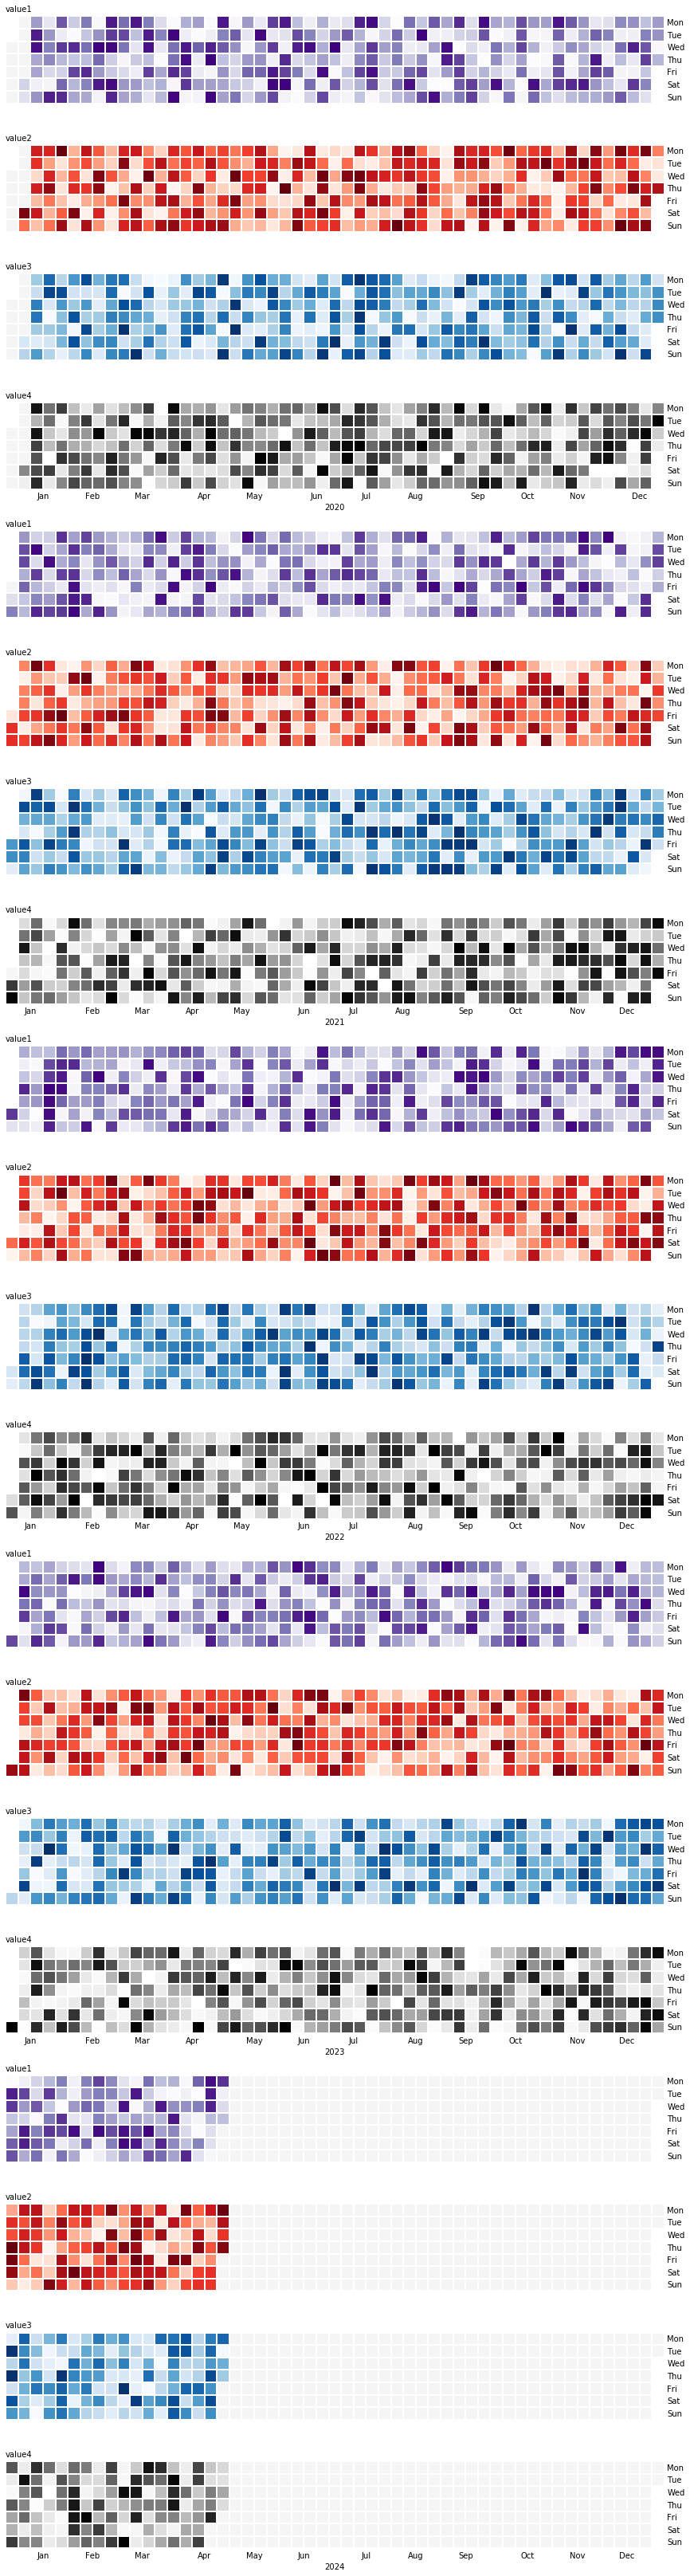

In [415]:
#year_heatmap(df, 'value', 'date')

#
#fig = year_heatmap(df, value_cols=['value1', 'value2','value3'])
#fig = year_heatmap(df, value_cols=['value1'])
#fig = year_heatmap(df, value_cols=['value1', 'value2'])
#fig = year_heatmap(df, value_cols=['value1', 'value2', 'value3'])
fig = year_heatmap(df, vgap=4, fsize=10)

In [233]:
fig.tight_layout()

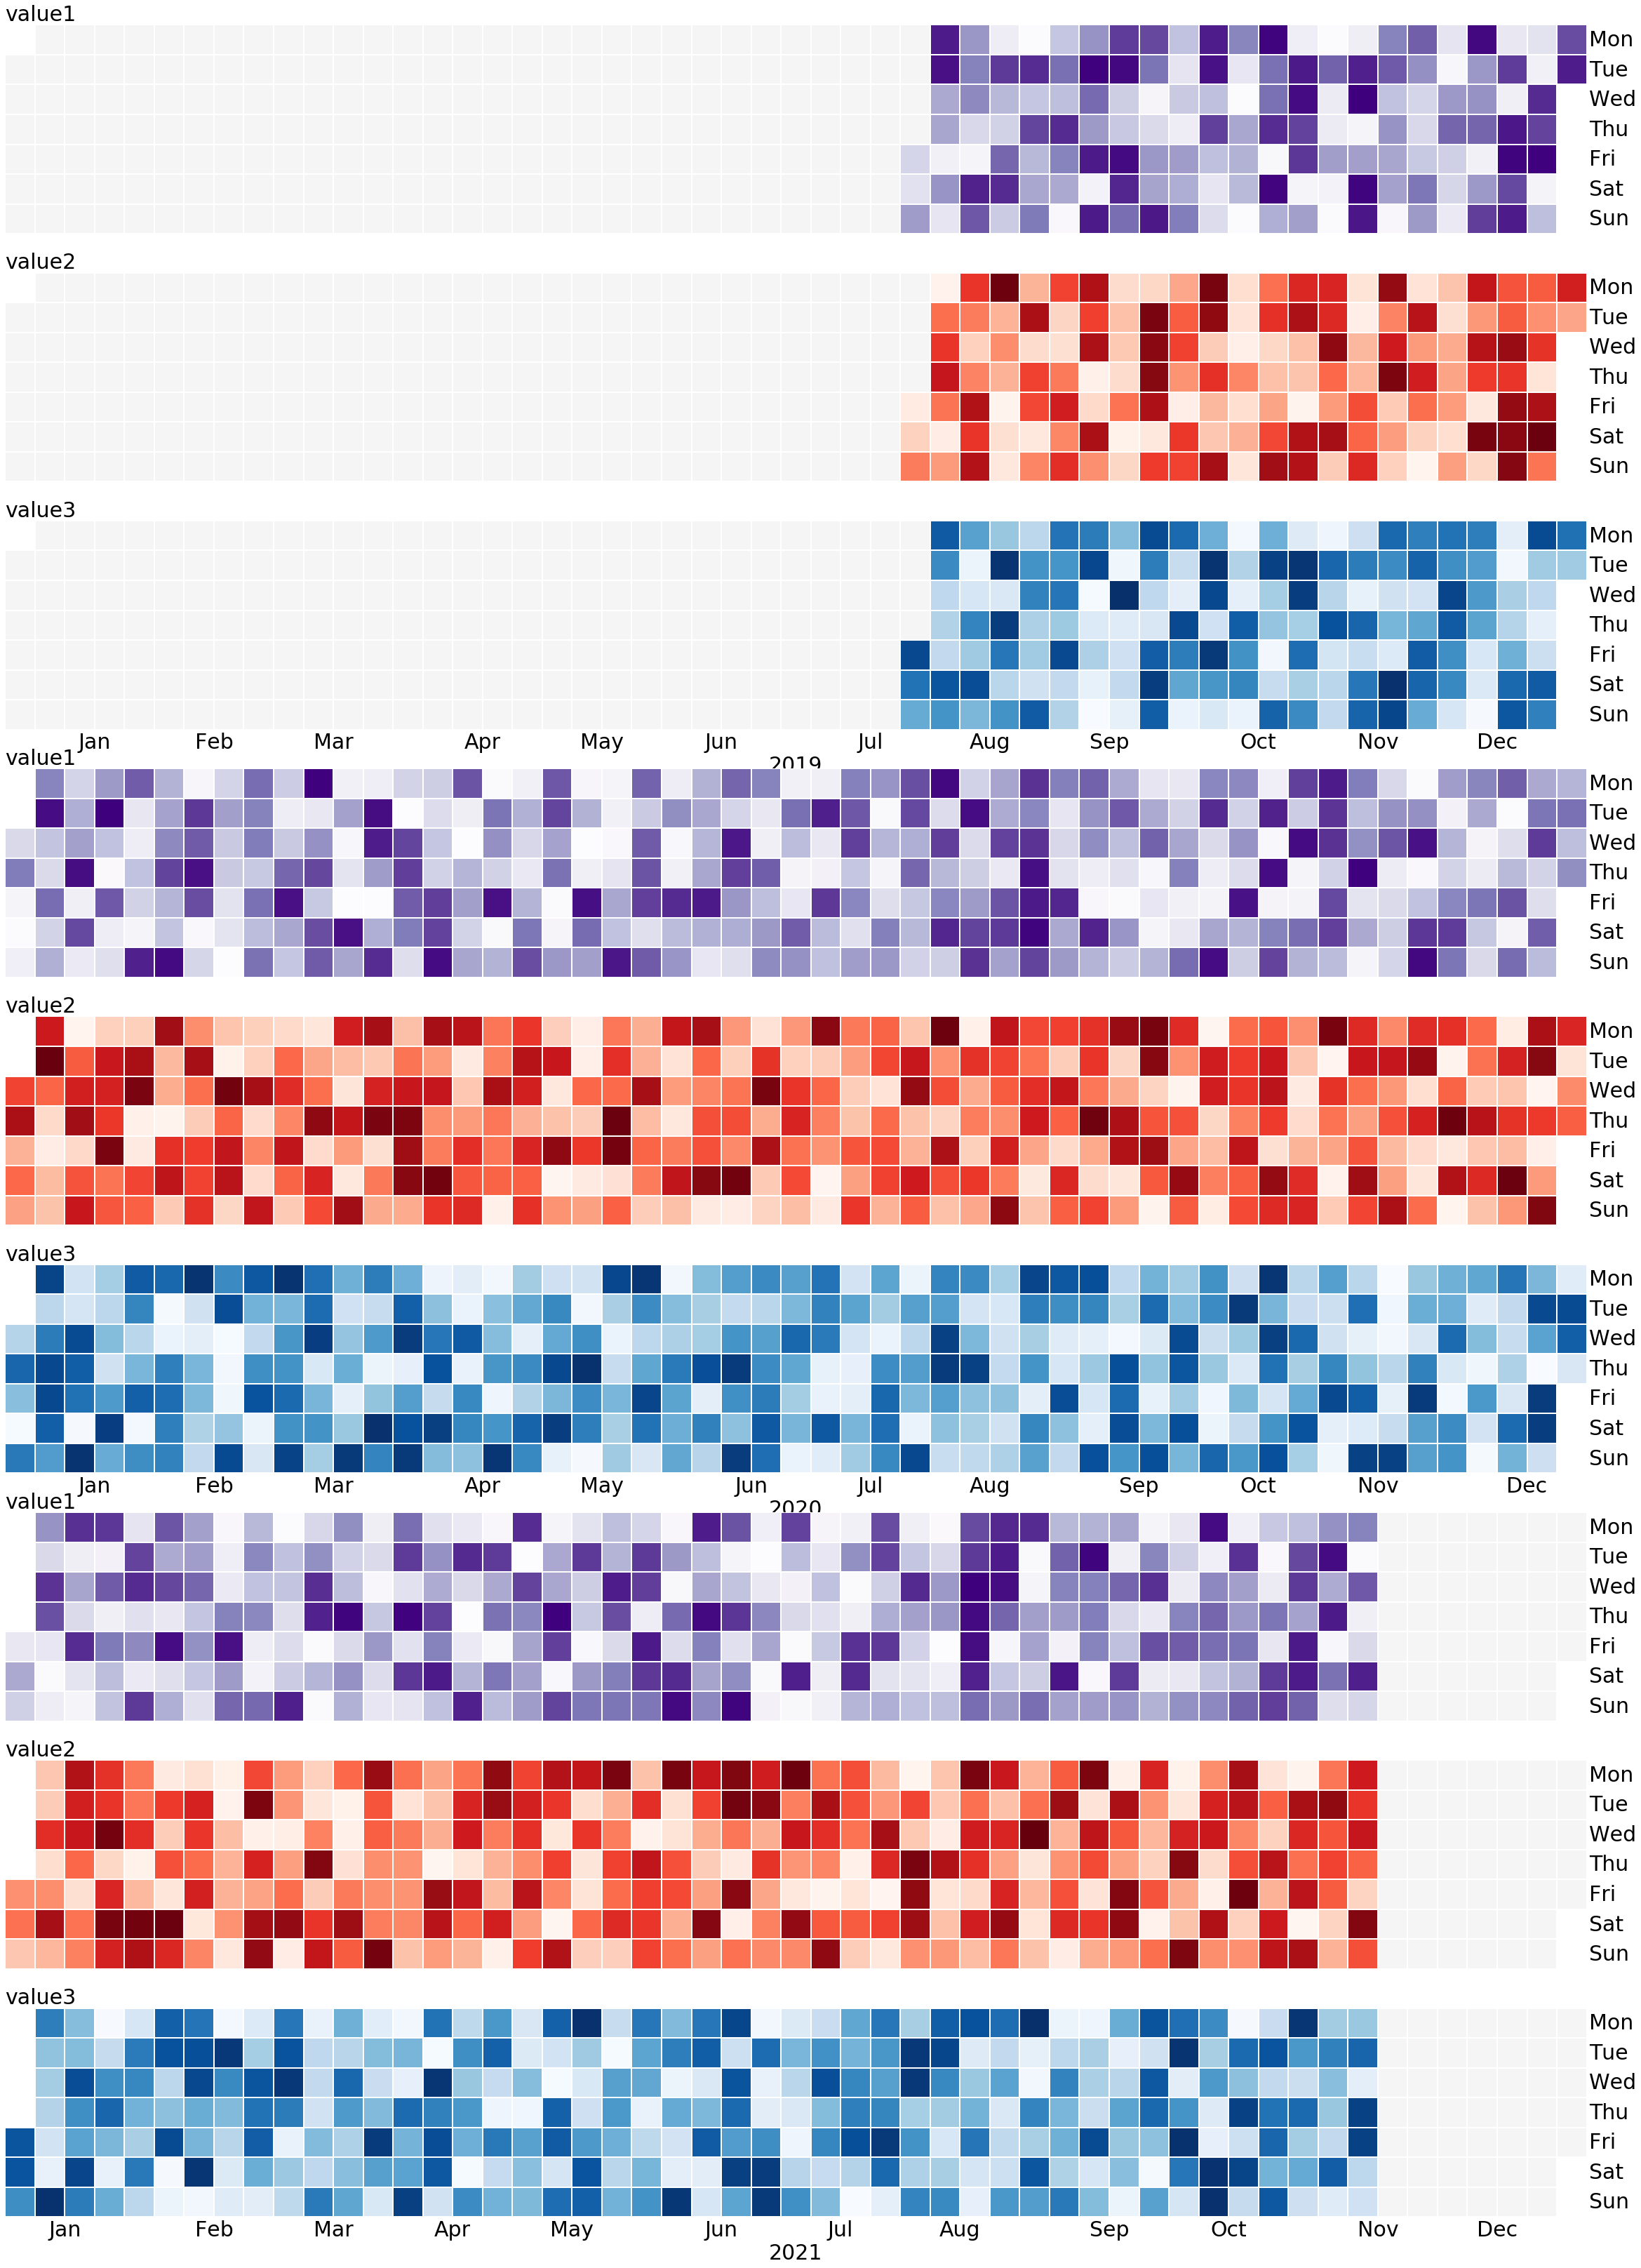

In [234]:
fig

In [231]:
# adjust subplot sizes
from matplotlib.gridspec import GridSpec
gs = GridSpec(13, 1, height_ratios=[1,1,1,0.4,1,1,1,0.4,1,1,1,0.4,1])
for i in range(6):
    x=i
    if i >2: x = x+1
    if i >6: x = x+1
    axes[i][0].set_position(gs[x].get_position(fig))

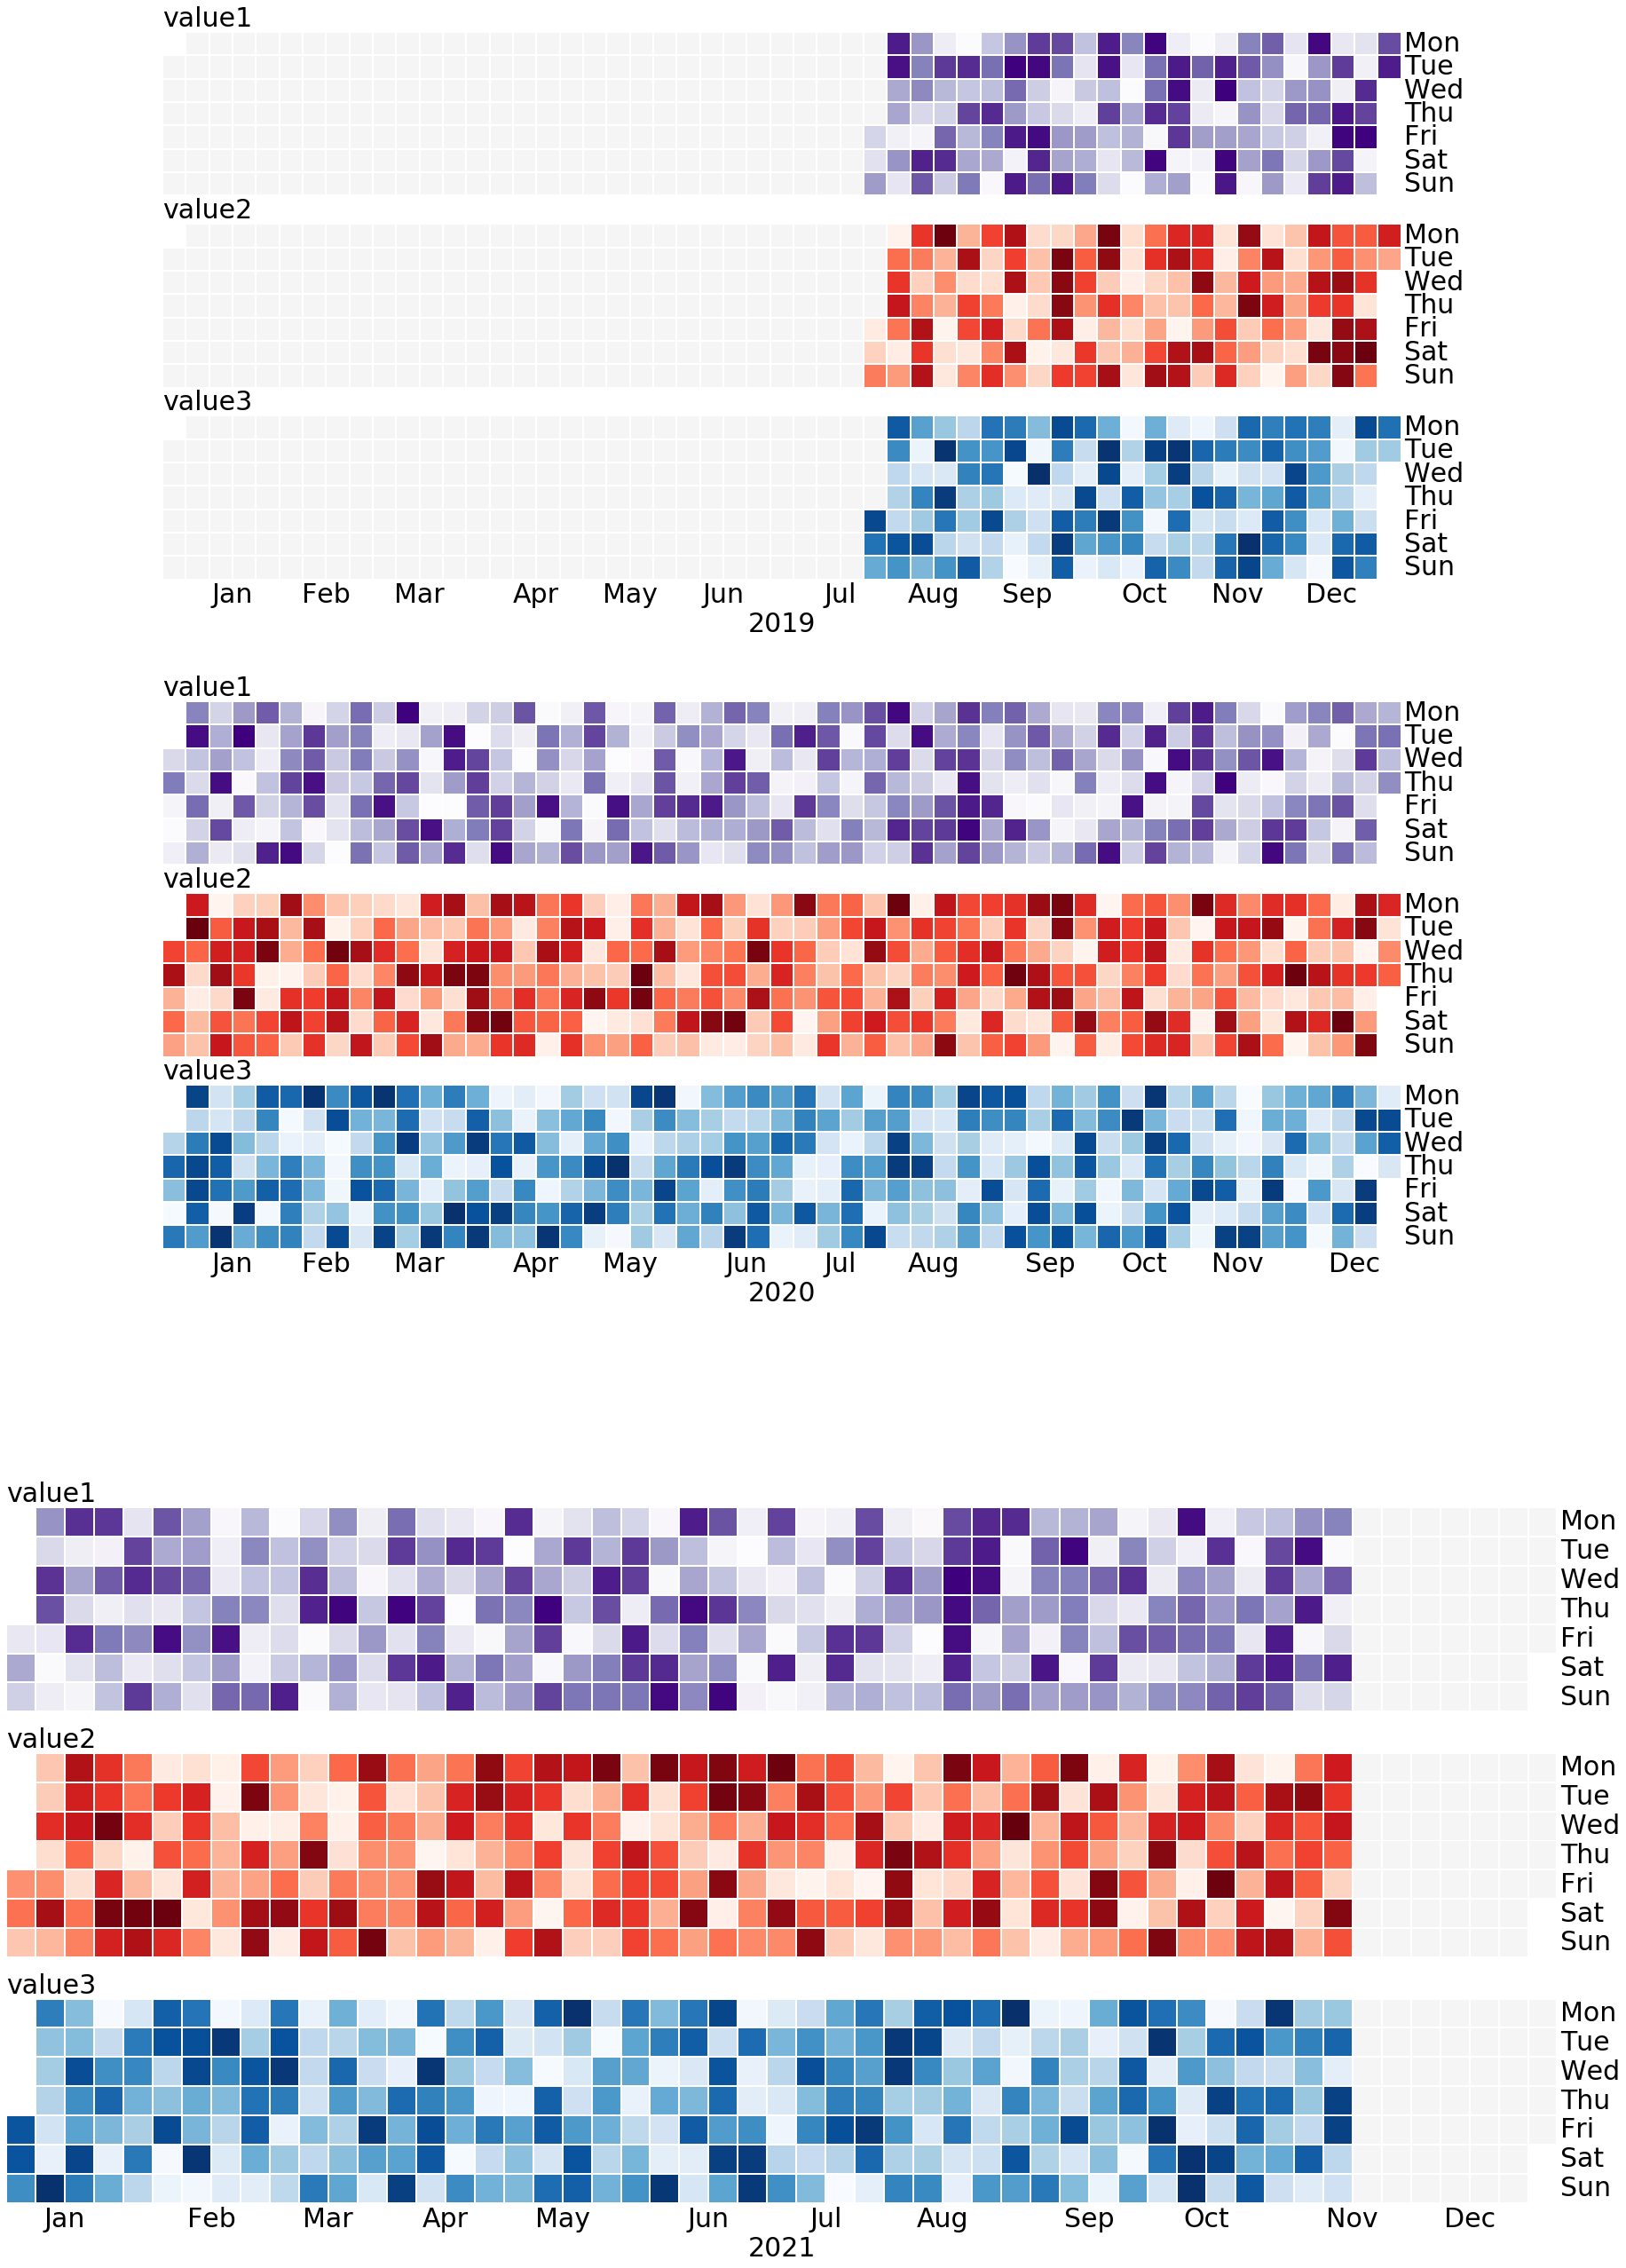

In [232]:
fig